# классификация сущностей (NER) с помощью кастомной трансформерной архитектуры 
Данильченко Вадим

План:
1. загрузить данные
2. токенизировать входящее сообщение
3. препроцессинг (нормализация)
4. создать словарь id:токен на токены фразы
5. преобразовать в последовательность id
6. выровнять до max_len последовательности
7. токенизировать разметку сущностей
8. создать словарь id:токен для сущностей
9. преобразовать в последовательность id
10. выровнять до max_len последовательности
11. train_test_split
12. модель
13. валидация

In [6]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Layer, MultiHeadAttention, Dense, Dropout, LayerNormalization, Embedding, TimeDistributed, Bidirectional, LSTM
from keras import Model
from sklearn.metrics import classification_report

1. загрузим данные

In [8]:
data = pd.read_excel('./ner_result_set.xlsx')
print(data.shape)
data.head(2)

(2104, 17)


,Unnamed: 0,Сообщение,partner\nПартнер (&PARTNER),city\nГород (&GEOX),street\nАдрес (&ADDR),Область (&OBL),product\nПродукт (&PROD),category\nКатегория (&CATEG),summa,Сущности от бота,Сущности разметка,Комментарий,incoming,entities,check,target_entities,readable
0,0.0,По сотовой связи,0.0,0.0,0.0,NaN,0.0,1.0,1.0,по сотовой связи,по &CATEG,NaN,по сотовой связи,O B-CATEG I-CATEG,0.0,O B-CATEG I-CATEG,"[('сотовой', 'B-CATEG'), ('связи', 'I-CATEG')]"
1,1.0,Добрый день . Оплатила за учебу картой Свобода...,0.0,1.0,0.0,NaN,1.0,0.0,2.0,оплатила за учебу картой свобода и сейчас поло...,оплатила за учебу картой &PROD и сейчас положи...,NaN,оплатила за учебу картой свобода и сейчас поло...,O O O O B-PROD O O O O O B-NUMI O O O O O O O ...,0.0,O O O O B-PROD O O O O O O O O O O O O O O O O...,"[('свобода', 'B-PROD')]"


2. токенизируем входящее сообщение

In [9]:
texts = data['incoming'].tolist()
text = []
for i in range(data.shape[0]):
  text.append(text_to_word_sequence(str(texts[i]).strip()))

print(len(text))
text[:2]

2104


[['по', 'сотовой', 'связи'],
 ['оплатила',
  'за',
  'учебу',
  'картой',
  'свобода',
  'и',
  'сейчас',
  'положила',
  'деньги',
  'прошло',
  '5',
  'дней',
  'я',
  'правильно',
  'поняла',
  'мне',
  'все',
  'равно',
  'сумму',
  'за',
  'карту',
  '1599',
  'нужно',
  'оплатить',
  'через',
  '10',
  'дней']]

3. препроцессинг (нормализация)

In [10]:
morh = MorphAnalyzer()

text_norm = [[] for _ in range(len(text))]

for i in range(data.shape[0]):
  for j in range(len(text[i])):
    tmp_elem = text[i][j]
    text_norm[i].append(morh.parse(tmp_elem)[0].normal_form)

print(len(text_norm))
text_norm[:2]

2104


[['по', 'сотовый', 'связь'],
 ['оплатить',
  'за',
  'учёба',
  'карта',
  'свобода',
  'и',
  'сейчас',
  'положить',
  'деньга',
  'пройти',
  '5',
  'день',
  'я',
  'правильно',
  'понять',
  'я',
  'всё',
  'равно',
  'сумма',
  'за',
  'карта',
  '1599',
  'нужно',
  'оплатить',
  'через',
  '10',
  'день']]

4. создать словарь id:токен на токены фразы

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_norm)

In [12]:
id2word = tokenizer.index_word
id2word[0] = 'pad'
len(id2word)

2887

5. преобразовать в последовательность id

In [13]:
sequences = tokenizer.texts_to_sequences(text_norm)
sequences[:2]

[[5, 640, 186],
 [52,
  21,
  1419,
  1,
  9,
  8,
  83,
  250,
  34,
  119,
  97,
  50,
  3,
  370,
  224,
  3,
  95,
  851,
  28,
  21,
  1,
  1420,
  78,
  52,
  48,
  32,
  50]]

6. выровнять до max_len последовательности

In [14]:
# посмотрим на max длину
max_len = 0
for elem in sequences:
  if len(elem)>max_len:
    max_len = len(elem)
# max_len = 12

In [15]:
sequences_pad = pad_sequences(sequences, maxlen=max_len, padding='post', value=0)
sequences_pad[:2]

array([[   5,  640,  186,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

7. токенизируем разметку сущностей

In [16]:
data['target_entities'].tail()

2099                                 O O PARTNER O O GEOX
2100                                    O O PARTNER O O O
2101                O O O O O O O CATEG PARTNER PARTNER O
2102    O O O O O O O O O O O PARTNER PARTNER O CATEG ...
2103                                O O O PROD O O O O O 
Name: target_entities, dtype: object

In [17]:
entities = data['target_entities'].tolist()

entities_list = []
for i in range(len(entities)):
  entities_list.append(str(entities[i]).strip().split(' '))

print(len(entities_list))
entities_list[:2]

2104


[['O', 'B-CATEG', 'I-CATEG'],
 ['O',
  'O',
  'O',
  'O',
  'B-PROD',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

8. создать словарь id:токен для сущностей

In [18]:
tokenizer_ent = Tokenizer()
tokenizer_ent.fit_on_texts(entities_list)

In [19]:
id2ent = tokenizer_ent.index_word
id2ent[0] = 'pad'
ent_num = len(id2ent)
print(ent_num)

20


In [20]:
id2ent

{0: 'pad',
 1: 'o',
 2: 'b-prod',
 3: 'partner',
 4: 'i-prod',
 5: 'categ',
 6: 'b-partner',
 7: 'prod',
 8: 'i-categ',
 9: 'b-categ',
 10: 'i-partner',
 11: 'geox',
 12: 'b-geox',
 13: 'addr',
 14: 'i-addr',
 15: 'obl',
 16: 'b-addr',
 17: 'i-geox',
 18: 'b-obl',
 19: 'i-obl'}

9. преобразовать в последовательность id

In [21]:
sequences_ent = tokenizer_ent.texts_to_sequences(entities_list)
sequences_ent[:2]

[[1, 9, 8],
 [1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]]

10. выровнять до max_len последовательности

In [22]:
# длина последовательности должна совпадать с входящей последовательностью
sequences_ent_pad = pad_sequences(sequences_ent, maxlen=max_len, padding='post', value=0)
sequences_ent_pad[:2]

array([[1, 9, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        

11. train_test_split

In [23]:
y_cat = [[to_categorical(i, num_classes=ent_num) for i in tmp_seq] for tmp_seq in sequences_ent_pad]
y_cat = np.asarray(y_cat)
y_cat[0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
# разделим на тренировочную и тестовую выборки

x_train, x_test, y_train, y_test = train_test_split(sequences_pad, y_cat, test_size=0.1, random_state=777)#, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1893, 161) (1893, 161, 20) (211, 161) (211, 161, 20)


12. модель

In [25]:
# опишем блок трансформера
class transformerLayer(Layer):
  
  def __init__(self, num_heads, embed_dim, fc_dim):
    super(transformerLayer, self).__init__()
    # self.num_head = num_heads
    # self.embed_dim = embed_dim
    # self.fc_dim = fc_dim
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.fc1 = Dense(fc_dim, activation='relu')
    self.fc2 = Dense(embed_dim)
    self.dp1 = Dropout(0.1)
    self.dp2 = Dropout(0.1)
    self.ln1 = LayerNormalization(epsilon=1e-6)
    self.ln2 = LayerNormalization(epsilon=1e-6)


  def call(self, inputs):
      att = self.att(inputs, inputs)
      dp = self.dp1(att)
      ln = self.ln1(inputs + dp)
      fc = self.fc1(ln)
      fc = self.fc2(fc)
      dp = self.dp2(fc)
      out = self.ln2(ln + dp)
      return out

In [26]:
# опишем класс эмбеддингов для позиционирования токенов
class tokenPositionLayer(Layer):
  
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(tokenPositionLayer, self).__init__()
    # self.maxlen = maxlen
    # self.vocab_size = vocab_size
    # self.embed_dim = embed_dim
    self.te = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pe = Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, inputs):
    maxlen = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    position_embedding = self.pe(positions)
    token_embedding = self.te(inputs)
    return position_embedding + token_embedding  

In [27]:
class entityModel(Model):

  def __init__(self, ent_num, vocab_size, maxlen, embed_dim, num_heads, fc_dim):
    super(entityModel, self).__init__()
    self.el = tokenPositionLayer(maxlen, vocab_size, embed_dim)
    self.tl1 = transformerLayer(num_heads=num_heads, embed_dim=embed_dim, fc_dim=fc_dim)
    self.dp1 = Dropout(0.1)
    # self.tl2 = transformerLayer(num_heads=num_heads, embed_dim=embed_dim, fc_dim=fc_dim)
    # self.dp2 = Dropout(0.1)
    # self.bd = Bidirectional(LSTM(100, return_sequences = True, recurrent_dropout=0.1))
    self.fc1 = Dense(fc_dim, activation='relu')
    self.dp3 = Dropout(0.1)
    self.fc2 = Dense(fc_dim, activation='relu')
    self.dp4 = Dropout(0.1)
    self.fc3 = Dense(ent_num, activation='softmax')

  def call(self, inputs):
    el = self.el(inputs)
    tl1 = self.tl1(el)
    dp1 = self.dp1(tl1)
    # tl2 = self.tl2(dp1)
    # dp2 = self.dp2(tl2)
    # bd = self.bd(dp2)
    fc1 = self.fc1(dp1)
    dp3 = self.dp3(fc1)
    fc2 = self.fc2(dp3)
    dp4 = self.dp4(fc2)
    out = self.fc3(dp4)
    return out

In [28]:
model = entityModel(ent_num=ent_num, 
                    vocab_size=len(id2word), 
                    maxlen=max_len, 
                    embed_dim=128, 
                    num_heads=4, 
                    fc_dim=128
                    )

In [29]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [30]:
history = model.fit(x_train, 
          y_train,
          validation_data=(x_test, y_test),
          epochs=10,
          batch_size=64,
          verbose=1
              )

Epoch 1/10
30/30 [==============================] - 38s 1s/step - loss: 0.5104 - accuracy: 0.8881 - val_loss: 0.1162 - val_accuracy: 0.9797
Epoch 2/10
30/30 [==============================] - 34s 1s/step - loss: 0.1286 - accuracy: 0.9774 - val_loss: 0.1007 - val_accuracy: 0.9797
Epoch 3/10
30/30 [==============================] - 38s 1s/step - loss: 0.1100 - accuracy: 0.9784 - val_loss: 0.0911 - val_accuracy: 0.9810
Epoch 4/10
30/30 [==============================] - 34s 1s/step - loss: 0.0949 - accuracy: 0.9791 - val_loss: 0.0773 - val_accuracy: 0.9811
Epoch 5/10
30/30 [==============================] - 33s 1s/step - loss: 0.0800 - accuracy: 0.9792 - val_loss: 0.0691 - val_accuracy: 0.9816
Epoch 6/10
30/30 [==============================] - 33s 1s/step - loss: 0.0713 - accuracy: 0.9804 - val_loss: 0.0646 - val_accuracy: 0.9823
Epoch 7/10
30/30 [==============================] - 35s 1s/step - loss: 0.0659 - accuracy: 0.9817 - val_loss: 0.0600 - val_accuracy: 0.9831
Epoch 8/10
30/30 [==

13. валидация

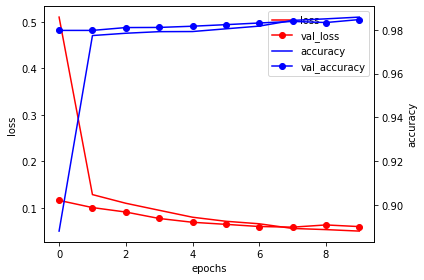

In [31]:
import matplotlib.pyplot as plt
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(history.history['accuracy']), 1)

ln1 = ax1.plot(t, history.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, history.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, history.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, history.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [32]:
id2ent

{0: 'pad',
 1: 'o',
 2: 'b-prod',
 3: 'partner',
 4: 'i-prod',
 5: 'categ',
 6: 'b-partner',
 7: 'prod',
 8: 'i-categ',
 9: 'b-categ',
 10: 'i-partner',
 11: 'geox',
 12: 'b-geox',
 13: 'addr',
 14: 'i-addr',
 15: 'obl',
 16: 'b-addr',
 17: 'i-geox',
 18: 'b-obl',
 19: 'i-obl'}

In [33]:
# посмотрим на результаты классификации в разрезе каждой именованной сущности
pred = model.predict(x_test)
pred_classes = pred.argmax(axis=-1)
report = classification_report(y_pred=np.hstack(pred_classes), y_true=np.hstack(np.argmax(y_test, axis=2)))
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     30531
           1       0.93      0.92      0.92      3093
           2       0.62      0.76      0.68        93
           3       0.51      0.36      0.42        53
           4       0.25      0.02      0.04        41
           5       0.67      0.35      0.46        46
           6       0.47      0.30      0.37        23
           7       1.00      0.12      0.22        16
           8       0.50      0.08      0.13        13
           9       0.75      0.23      0.35        13
          10       0.00      0.00      0.00        12
          11       1.00      0.14      0.25         7
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00        16
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         1

    accuracy                           0.98     33971
   macro avg       0.48   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ВЫВОДЫ: результат определения сущностей по кастомной трансформерной архитектуре не самый лучший, все же интереснее результаты с двунаправленной рекуррентной нейросетью, но для предварительного теста достаточно, дальше нужно больше поработать над составом слоев